# Summary

* There is not consensus on the feature associating the largest variance between feature sets.
* The general amount of feature variance increases with reduced amount of artifacts in the images through slice removal.

In [1]:
import sys
sys.path.append('./../prepping/')

import numpy as np
import pandas as pd

from scipy import linalg
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.spatial import distance

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Original Images Features

In [2]:
_y_orig = pd.read_csv('./../../data_source/to_analysis/original_images/dfs_original_images.csv', index_col=0)
y_orig = np.squeeze(_y_orig.values)

X_orig = pd.read_csv('./../../data_source/to_analysis/original_images/all_features_original_images.csv',index_col=0)
X_orig.head()

,Age,Years Smoking,Naxogin Days,Sex_M,ICD-10_C02,ICD-10_C03,ICD-10_C04,ICD-10_C05,ICD-10_C06,ICD-10_C09,...,PET_original_ngtdm_Complexity_128bins,PET_original_ngtdm_Contrast_32bins,PET_original_ngtdm_Contrast_64bins,PET_original_ngtdm_Contrast_128bins,PET_original_ngtdm_Strength_32bins,PET_original_ngtdm_Strength_64bins,PET_original_ngtdm_Strength_128bins,PETparam_SUVpeak,PETparam_MTV,PETparam_TLG
2,60.832877,0.000000,39.0,1,0,0,0,0,0,1,...,47916.617451,0.094457,0.178525,0.358043,6.057050,25.566977,101.349019,21.616549,7.384,124.870726
4,49.906849,4.786027,33.0,0,0,0,0,0,0,1,...,19579.702532,0.070352,0.125185,0.238295,6.021110,27.043416,112.933552,15.296275,3.406,41.554406
5,54.238356,0.000000,42.0,0,0,0,0,0,0,1,...,14251.207526,0.054852,0.099392,0.191019,2.465487,10.711840,44.417785,14.473272,7.934,86.228420
8,54.687671,18.343836,0.0,1,0,0,0,0,0,0,...,7766.277251,0.024052,0.038650,0.070961,0.557200,2.723527,11.765552,10.510859,26.926,205.413389
10,61.728767,0.000000,35.0,1,0,0,0,0,0,0,...,2229.551107,0.029594,0.044499,0.082635,0.583427,3.013379,12.730022,7.213190,6.041,32.103770


In [3]:
X_orig.shape

(198, 513)

In [4]:
X_orig_shape = X_orig.filter(regex='shape')
X_orig_PET = X_orig.filter(regex='PET')
X_orig_CT = X_orig.filter(regex='CT')

X_orig_shape.shape, X_orig_PET.shape, X_orig_CT.shape

((198, 14), (198, 228), (198, 229))

In [5]:
scaler = StandardScaler()

X_orig_shape_std = scaler.fit_transform(X_orig_shape)
X_orig_PET_std = scaler.fit_transform(X_orig_PET)
X_orig_CT_std = scaler.fit_transform(X_orig_CT)

X_orig_shape_std.shape, X_orig_PET_std.shape, X_orig_CT_std.shape

((198, 14), (198, 228), (198, 229))

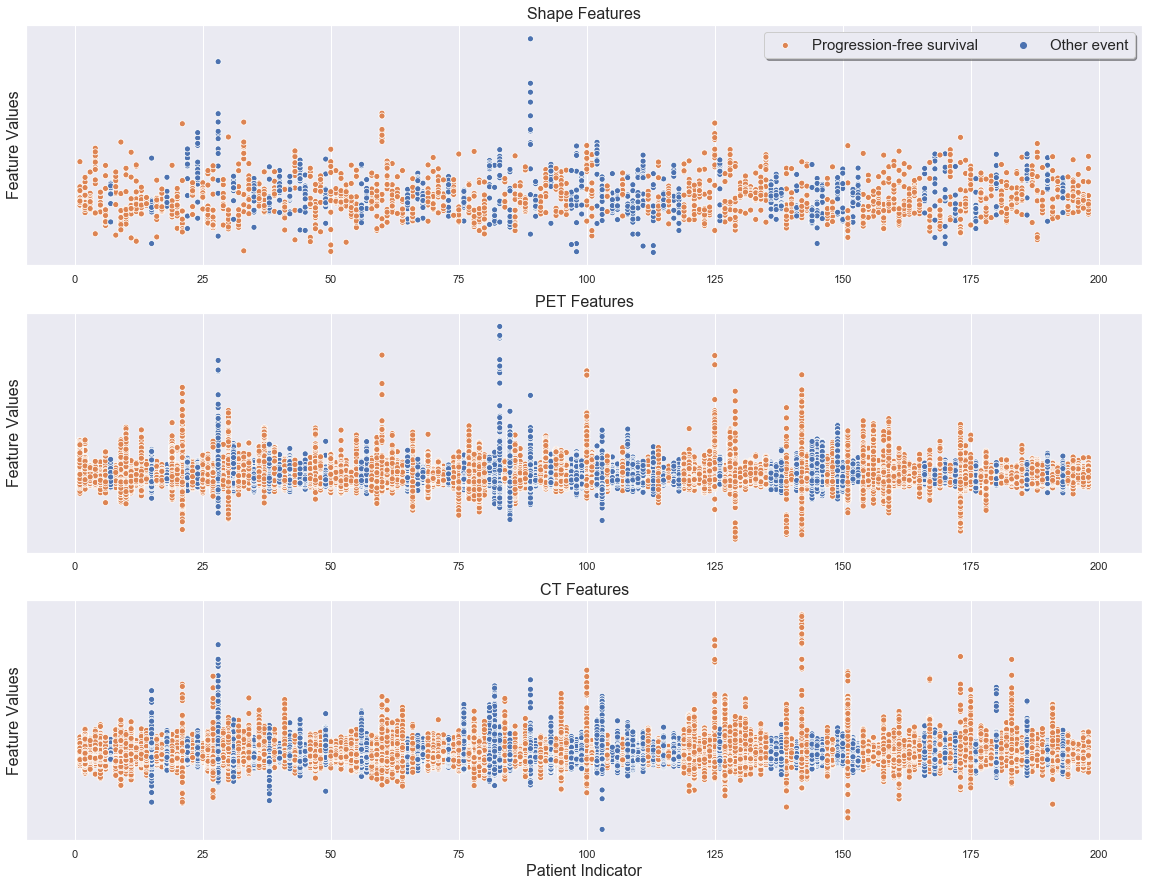

In [34]:
_hue = y_orig==0
x_coords = np.arange(1, np.size(y_orig) + 1)

sns.set()
fig, axis = plt.subplots(
    nrows=3, figsize=(20, 15)
)
axis[0].set_title('Shape Features', fontsize=16)
for shape_col in X_orig_shape_std.T:
    sns.scatterplot(
        x=x_coords,
        y=shape_col,
        hue=_hue,
        #legend=False,
        ax=axis[0]
    )
axis[0].set_ylabel('Feature Values', fontsize=16)
axis[0].set_yticks([])
axis[0].legend(
    labels=['Progression-free survival', 'Other event'],
    #loc='upper center', bbox_to_anchor=(0.5, 1.2),
    ncol=2, fancybox=True, shadow=True, fontsize=15)

axis[1].set_title('PET Features', fontsize=16)
for PET_col in X_orig_PET_std.T:
    sns.scatterplot(
        x=x_coords,
        y=PET_col,
        hue=_hue,
        legend=False,
        ax=axis[1]
    )
axis[1].set_ylabel('Feature Values', fontsize=16)
axis[1].set_yticks([])

axis[2].set_title('CT Features', fontsize=16)
for CT_col in X_orig_CT_std.T:
    sns.scatterplot(
        x=x_coords,
        y=CT_col,
        hue=_hue,
        legend=False,
        ax=axis[2]
    )
axis[2].set_ylabel('Feature Values', fontsize=16)
axis[2].set_yticks([])

plt.xlabel('Patient Indicator', fontsize=16)

plt.savefig(
    './scatter_radiom_orig.png', 
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

# Removed Broken Images and Slices Features

In [7]:
y_rs = np.squeeze(pd.read_csv('./../../data_source/to_analysis/removed_broken_slices/dfs_removed_broken_slices.csv', index_col=0).values)
X_rs = pd.read_csv('./../../data_source/to_analysis/removed_broken_slices/all_features_removed_broken_slices.csv',index_col=0)
X_rs.head()

,Age,Years Smoking,Naxogin Days,Sex_M,ICD-10_C02,ICD-10_C03,ICD-10_C04,ICD-10_C05,ICD-10_C06,ICD-10_C09,...,PET_original_ngtdm_Complexity_128bins,PET_original_ngtdm_Contrast_32bins,PET_original_ngtdm_Contrast_64bins,PET_original_ngtdm_Contrast_128bins,PET_original_ngtdm_Strength_32bins,PET_original_ngtdm_Strength_64bins,PET_original_ngtdm_Strength_128bins,PETparam_SUVpeak,PETparam_MTV,PETparam_TLG
2,60.832877,0.000000,39.0,1,0,0,0,0,0,1,...,1599.947132,0.000976,0.001620,0.003897,0.396557,1.693934,5.567880,21.616549,7.384,124.870726
4,49.906849,4.786027,33.0,0,0,0,0,0,0,1,...,3217.512365,0.008073,0.014372,0.027189,0.397361,1.633211,6.700313,15.296275,3.406,41.554406
5,54.238356,0.000000,42.0,0,0,0,0,0,0,1,...,3942.905646,0.002888,0.005451,0.012323,0.624495,2.548930,8.394449,14.473272,7.934,86.228420
8,54.687671,18.343836,0.0,1,0,0,0,0,0,0,...,8287.868760,0.001761,0.002913,0.005929,0.382945,1.838921,7.536450,10.510859,26.926,205.413389
10,61.728767,0.000000,35.0,1,0,0,0,0,0,0,...,2522.544332,0.002270,0.003587,0.008162,0.622817,2.614514,9.277804,7.213190,6.041,32.103770


In [8]:
X_rs.shape

(187, 513)

In [9]:
X_rs_shape = X_rs.filter(regex='shape')
X_rs_PET = X_rs.filter(regex='PET')
X_rs_CT = X_rs.filter(regex='CT')

X_rs_shape.shape, X_rs_PET.shape, X_rs_CT.shape

((187, 14), (187, 228), (187, 229))

In [10]:
scaler = StandardScaler()

X_rs_shape_std = scaler.fit_transform(X_rs_shape)
X_rs_PET_std = scaler.fit_transform(X_rs_PET)
X_rs_CT_std = scaler.fit_transform(X_rs_CT)

X_rs_shape_std.shape, X_rs_PET_std.shape, X_rs_CT_std.shape

((187, 14), (187, 228), (187, 229))

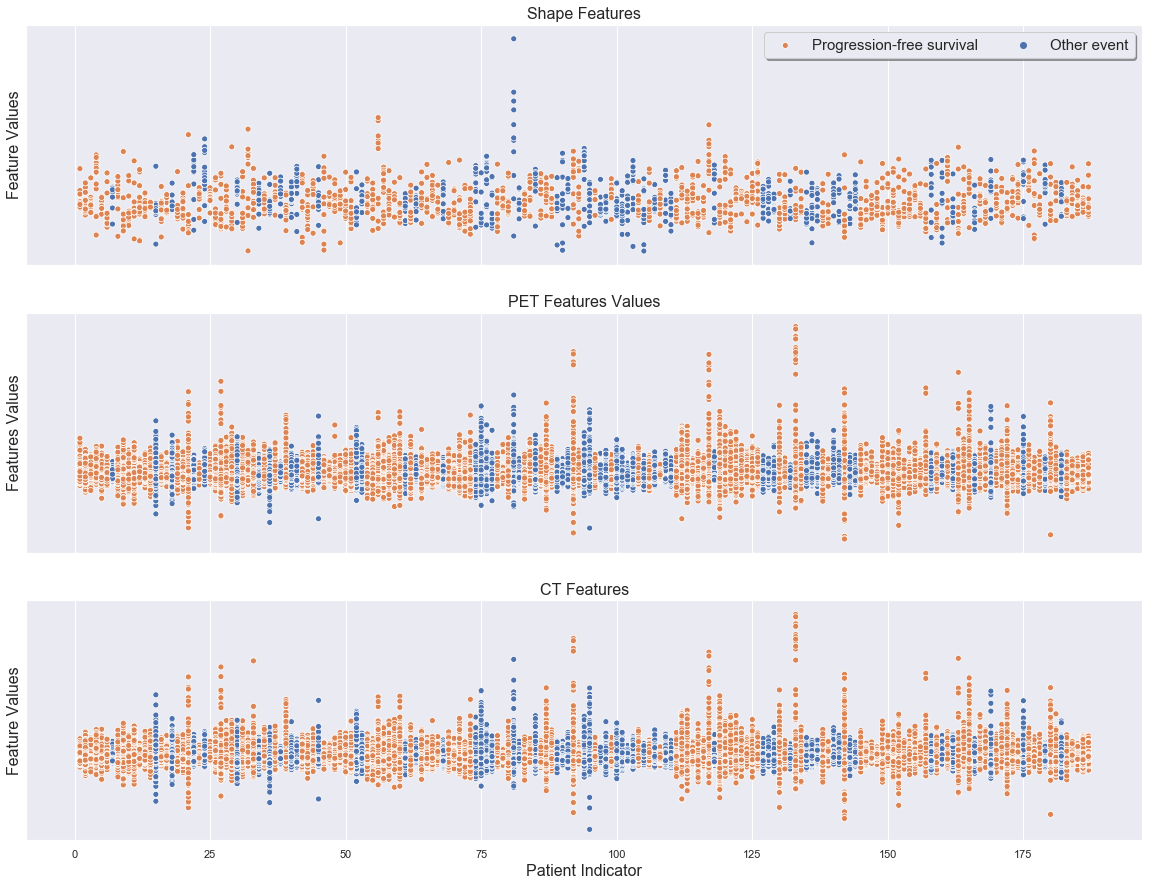

In [45]:
# TODO: Legend with outcome labels.

_hue = y_rs==0
x_coords = np.arange(1, np.size(y_rs) + 1)

sns.set()
fig, axis = plt.subplots(
    nrows=3, 
    sharex=True,
    figsize=(20, 15)
)
axis[0].set_title('Shape Features', fontsize=16)
for shape_col in X_rs_shape_std.T:
    sns.scatterplot(
        x=x_coords,
        y=shape_col,
        hue=_hue,
        #legend=True,
        ax=axis[0]
    )
axis[0].set_ylabel('Feature Values', fontsize=16)
axis[0].set_yticks([])
axis[0].legend(
    labels=['Progression-free survival', 'Other event'],
    #loc='upper center', bbox_to_anchor=(0.5, 1.2),
    ncol=2, fancybox=True, shadow=True, fontsize=15)

axis[1].set_title('PET Features Values', fontsize=16)
for PET_col in X_rs_PET_std.T:
    sns.scatterplot(
        x=x_coords,
        y=PET_col,
        hue=_hue,
        legend=False,
        ax=axis[1]
    )
axis[1].set_ylabel('Features Values', fontsize=16)
axis[1].set_yticks([])

axis[2].set_title('CT Features', fontsize=16)
for CT_col in X_rs_CT_std.T:
    sns.scatterplot(
        x=x_coords,
        y=CT_col,
        hue=_hue,
        legend=False,
        ax=axis[2]
    )
axis[2].set_ylabel('Feature Values', fontsize=16)
axis[2].set_yticks([])

plt.xlabel('Patient Indicator', fontsize=16)

plt.savefig(
    './scatter_radiom_reduced.png', 
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

# Feature Variance Original Images

In [80]:
def format_feature_labels(labels):
    """Process raw feature labels."""
    prep_labels = []
    for label in labels:
        #print(label)
        comps = label.split('_')
        if len(comps) == 1:
            prep_labels.append(label.title())
        elif len(comps) == 2:
            new_label = f'{comps[0]}: {comps[1]}'
            prep_labels.append(new_label)
        elif len(comps) == 3:
            filter_type, feature_type, name = comps
            if len(name) > 15:
                new_label = '{}'.format(name)
            else:
                new_label = '{}'.format(name)
            prep_labels.append(new_label)
        elif len(comps) == 4:
            image_type, filter_type, feature_type, name = comps
            if len(name) > 15:
                new_label = f'{name}'
            else:
                new_label = f'{name}'
            prep_labels.append(new_label)
        elif len(comps) == 5:
            image_type, _, _, name, _ = comps
            if len(name) > 15:
                new_label = f'{name}'
            else:
                new_label = f'{name}'
            prep_labels.append(new_label)
        else:
            raise ValueError('Label more than 5 comps!')
            
    return prep_labels

In [19]:
# Original images.
X_orig_no_clinical = pd.concat((X_orig_shape, X_orig_PET, X_orig_CT), axis=1)
X_orig_no_clinical = X_orig_no_clinical / X_orig_no_clinical.max(axis=0)

X_orig_vars = X_orig_no_clinical.var()
X_orig_max_var = X_orig_vars.max()
print(X_orig_max_var)
list(X_orig_no_clinical.columns[np.where(X_orig_max_var == X_orig_vars)])

0.19838359087431504


['CT_original_firstorder_Skewness']

In [37]:
# Removed broken slives.
X_rs_no_clinical = pd.concat((X_rs_shape, X_rs_PET, X_rs_CT), axis=1)
X_rs_no_clinical = X_rs_no_clinical / X_rs_no_clinical.max(axis=0)

X_rs_vars = X_rs_no_clinical.var()
X_rs_max_var = X_rs_vars.max()
print(X_rs_max_var)
list(X_rs_no_clinical.columns[np.where(X_rs_max_var == X_rs_vars)])

0.3337013430016588


['PET_original_glcm_ClusterShade_32bins',
 'CT_original_glcm_ClusterShade_32bins']

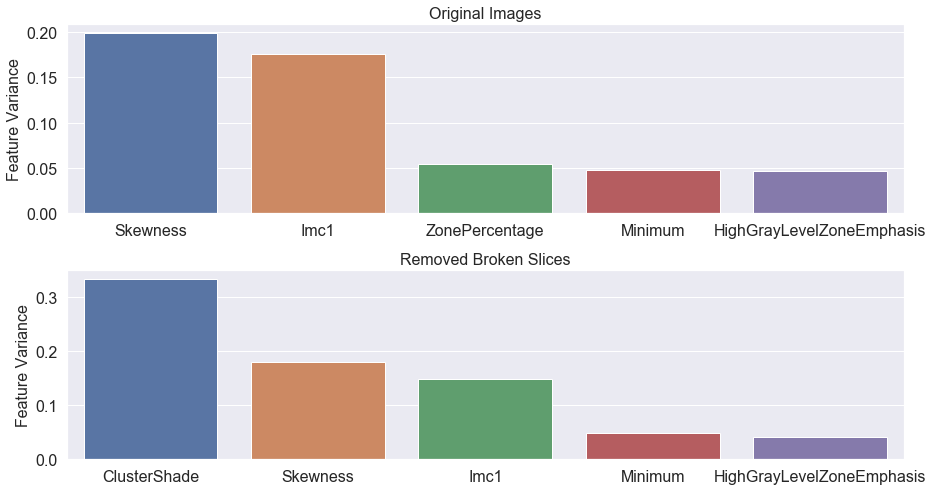

In [91]:
# The top n largest feature variances.
n = 5
x_coords = np.arange(n)

X_orig_vars_sorted = X_orig_vars.sort_values(inplace=False, ascending=False)
X_rs_vars_sorted = X_rs_vars.sort_values(inplace=False, ascending=False)

rs_vars = {}
for idx, val in zip(X_rs_vars_sorted.index, X_rs_vars_sorted):
    name = format_feature_labels([idx])[0]
    if name in rs_vars.keys():
        pass
    else:
        rs_vars[name] = val
        
orig_vars = {}
for idx, val in zip(X_orig_vars_sorted.index, X_orig_vars_sorted):
    name = format_feature_labels([idx])[0]
    if name in orig_vars.keys():
        pass
    else:
        orig_vars[name] = val

sns.set()
fig, axes = plt.subplots(nrows=2, figsize=(15, 8))
sns.barplot(
    x=list(orig_vars.keys())[:n],
    y=list(orig_vars.values())[:n],
    ax=axes[0]
)
sns.barplot(
    x=list(rs_vars.keys())[:n],
    y=list(rs_vars.values())[:n],
    ax=axes[1]
)
axes[0].set_title('Original Images', fontsize=16)
axes[1].set_title('Removed Broken Slices', fontsize=16)

axes[0].set_ylabel('Feature Variance', fontsize=16)
axes[1].set_ylabel('Feature Variance', fontsize=16)

axes[0].tick_params(labelsize=16)
axes[1].tick_params(labelsize=16)

plt.subplots_adjust(hspace=0.3)

plt.savefig(
    './radiom_feature_vars.png', 
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

In [92]:
orig_vars['ClusterShade']

0.01954798335598156

In [96]:
rs_vars['ClusterShade']

0.3337013430016588